<a href="https://colab.research.google.com/github/meth00/meth00/blob/main/coxtime_survival_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycox
!pip install lifelines

# Libraries loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper

import torch
import torch.nn as nn
import torchtuples as tt

from lifelines import CoxPHFitter
from pycox.models import CoxPH as deepsurv # for DeepSurv
from pycox.models import CoxTime # for Cox-time
from pycox.models.cox_time import MLPVanillaCoxTime # for optmization
from pycox.evaluation import EvalSurv # for model evaluation

In [ ]:
# Set seed to make this reproducable.
np.random.seed(1234)
_ = torch.manual_seed(123)

# Data loading

In [ ]:
from pycox.datasets import gbsg
df = gbsg.read_df()

In [ ]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,duration,event
0,0.0,0.0,0.0,32.0,1.0,155.0,168.0,84.000000,0
1,0.0,1.0,0.0,27.0,1.0,717.0,95.0,84.000000,0
2,0.0,1.0,1.0,52.0,1.0,120.0,437.0,84.000000,0
3,0.0,0.0,0.0,28.0,1.0,251.0,11.0,84.000000,0
4,0.0,0.0,0.0,39.0,1.0,241.0,92.0,66.234085,1


In [ ]:
# Summary of the dataset
pd.DataFrame({
    "Total Observations": [len(df)],
    "Censored (Event=0)": [(df['event'] == 0).sum()],
    "Observed Events (Event=1)": [(df['event'] == 1).sum()],
    "Number of Features": [df.shape[1] - 2]
}, index=["gbsd"])

,Total Observations,Censored (Event=0),Observed Events (Event=1),Number of Features
gbsd,2232,965,1267,7


# Data formatting

In [ ]:
# Train, validation and test
df_train, df_test = train_test_split(df,test_size=0.2, random_state=42
)
df_train, df_val = train_test_split(df_train,test_size=0.2, random_state=42
)

Features standardization

In [ ]:
features = df.columns.drop(['event', 'duration'])
standardize = [([col], StandardScaler()) for col in features]
x_mapper = DataFrameMapper(standardize)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

Target standardization

In [ ]:
labtrans = CoxTime.label_transform()

get_target = lambda df: (df['duration'].values, df['event'].values)

y_train = labtrans.fit_transform(*get_target(df_train))
durations_test, events_test = get_target(df_test)

y_val = labtrans.transform(*get_target(df_val))
val = tt.tuplefy(x_val, y_val)

In [ ]:
get_target(df_train)

(array([15.737166, 38.01232 , 84.      , ..., 35.81109 , 17.774128,
        44.451744], dtype=float32),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int32))

# Coxtime

## Proportional Hazard assumption

In [ ]:
# Fit a Cox model
cph = CoxPHFitter()
cph.fit(df, duration_col="duration", event_col="event")

# Perform Schoenfeld residuals test
cph.check_assumptions(df, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2232 total observations, 965 right-censored observations>
         test_name = proportional_hazard_test

---
         test_statistic      p  -log2(p)
x0 km              5.99   0.01      6.12
   rank            5.85   0.02      6.01
x1 km              7.29   0.01      7.18
   rank            7.41   0.01      7.27
x2 km              4.24   0.04      4.66
   rank            4.20   0.04      4.63
x3 km              2.68   0.10      3.30
   rank            2.45   0.12      3.09
x4 km              0.06   0.80      0.32
   rank            0.06   0.81      0.30
x5 km              8.89 <0.005      8.45
   rank            8.33 <0.005      8.00
x6 km             16.15 <0.005     14.06
   rank           16.25 <0.005     14.14



1. Variable 'x0' failed the non-proportional test: p-value is 0.0144.

   Advice: with so few unique values (only 2), you can include `strata=['x0', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable 'x1' failed the non-proportional test: p-value is 0.0065.

   Advice: with so few unique values (only 3), you can include `strata=['x1', ...]` in the call in
`.fit`. See documentation in link [E] below.

3. Variable 'x2' failed the non-proportional test: p-value is 0.0394.

   Advice: with so few unique values (only 2), you can include `strata=['x2', ...]` in the call in
`.fit`. See documentation in link [E] below.

4. Variable 'x5' failed the non-proportional test: p-value is 0.0029.

   Advice 1: the functional form of the variable 'x5' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.


[]

## Neural network

This is simple MLP with two hidden layers, ReLU activations, batch norm and dropout.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Extracted from  George H. Chen (survival_intro) to resolve nn.forward error

num_input_features = x_train.shape[1] + 1  # add 1 more for time
base_neural_net = nn.Sequential(
    nn.Linear(num_input_features, 64),  # Input to First Hidden Layer
    nn.BatchNorm1d(64),                 # Batch Normalization
    nn.ReLU(),                          # Activation
    nn.Dropout(0.2),                    # Dropout

    nn.Linear(64, 32),                   # First Hidden to Second Hidden Layer
    nn.BatchNorm1d(32),                  # Batch Normalization
    nn.ReLU(),                           # Activation
    nn.Dropout(0.2),                     # Dropout
nn.Linear(32, 1)).to(device)

# PyCox's CoxTime expects the base neural net's forward function to take in two
# separate inputs: the features and time (take a look at the forward function)

class CoxTimeBaseNeuralNetWrapper(nn.Module):
    def __init__(self, base_neural_net):
        super(CoxTimeBaseNeuralNetWrapper, self).__init__()
        self.net = base_neural_net

    def forward(self, inputs_excluding_times, times):
        inputs = torch.cat([inputs_excluding_times, times], dim=1)
        return self.net(inputs)

base_neural_net_wrapper = CoxTimeBaseNeuralNetWrapper(base_neural_net)


We have built a feed forward neural network with 2 hidden layers.

## Model training

In [ ]:
model_Coxtime = CoxTime(base_neural_net_wrapper, labtrans = labtrans, optimizer= tt.optim.Adam(lr = 0.1))

In [ ]:
batch_size = 364
epochs = 70
callbacks = [tt.callbacks.EarlyStopping(patience=20)]
verbose = False

log = model_Coxtime.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

/usr/local/lib/python3.11/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


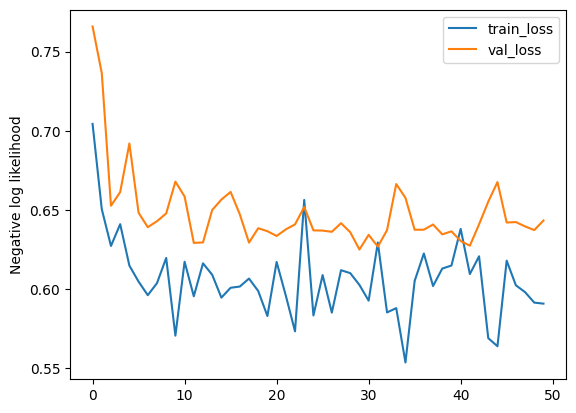

In [ ]:
_ = log.plot()
plt.ylabel('Negative log likelihood');

In [ ]:
model_Coxtime.partial_log_likelihood(*val).mean()

-5.244916

## Prediction

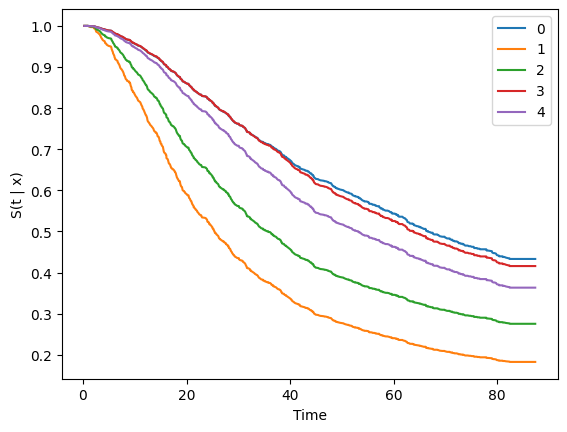

In [ ]:
lambda_0 = model_Coxtime.compute_baseline_hazards() # Baseline hazard function (Beslow estimaton)
surv = model_Coxtime.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

C-index: 0.66


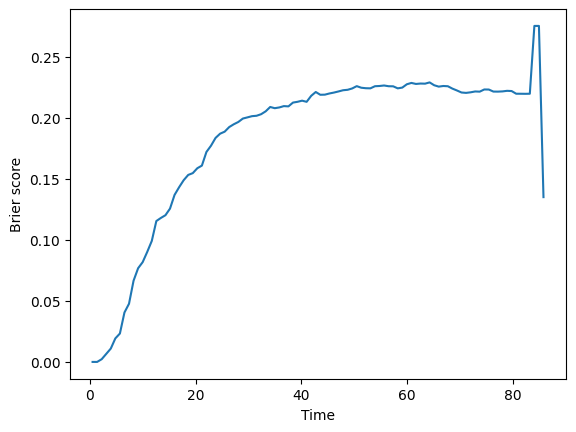

In [ ]:
print("C-index: {:.2f}".format(ev.concordance_td()))
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot(xlabel="Time", ylabel="Brier score")

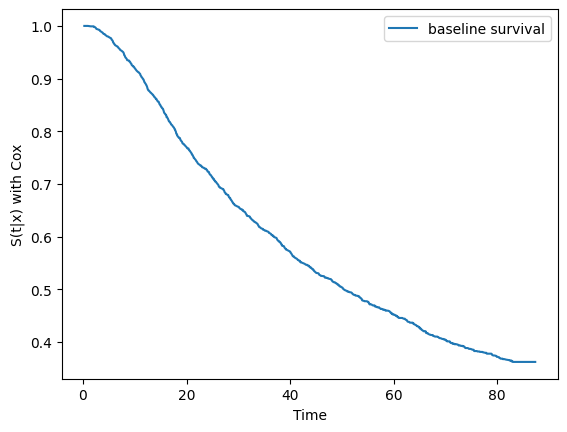

In [ ]:
cph.baseline_survival_.plot()
plt.ylabel('S(t|x) with Cox')
_ = plt.xlabel('Time')